In [42]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [43]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

In [44]:
# Загрузим игрушечный датасет из sklearn
iris = datasets.load_iris()
X = iris.data
X.shape

(150, 4)

# Задание 1

Обучить любую модель классификации на датасете IRIS до применения PCA (2 компоненты) и после него. Сравнить качество классификации по отложенной выборке.

### Решение

In [45]:
def e_metrics(x1, x2):

    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

In [46]:
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

In [47]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [48]:
X, y = load_iris(return_X_y=True)
X = iris.data
# X = X[:, :2]
X.shape

(150, 4)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

In [50]:
k = 100

y_pred_train = knn(X_train, y_train, X_train, k)
y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма на трейне при k = {k}: {accuracy(y_pred_train, y_train):.3f}')
print(f'Точность алгоритма на тесте при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма на трейне при k = 100: 0.500
Точность алгоритма на тесте при k = 100: 0.467


Обработаем данные при помощи PCA

In [51]:
def standard_scale(x):
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return res

In [52]:
# Для начала отмасштабируем выборку
X = X.astype(float)

X = standard_scale(X)

In [53]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X.T @ X

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения и собственные векторы в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения и собственные векторы в порядке убывания:
(437.77467247979894, array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654]))
(137.10457072021055, array([-0.37741762, -0.92329566, -0.02449161, -0.06694199]))
(22.01353133569725, array([-0.71956635,  0.24438178,  0.14212637,  0.63427274]))
(3.1072254642929513, array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))


Оценим долю дисперсии, которая описывается найденными компонентами.

In [54]:
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[72.96244541329986, 22.85076178670177, 3.668921889282877, 0.5178709107154922]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


Первые две компоненты описывают 94% информации. Отбрасываем две последние компоненты

In [55]:
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack([eig_pairs[i][1].reshape(4,1) for i in range(2)])

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [56]:
# Сформируем новую матрицу "объекты-признаки"
Z = X.dot(W)

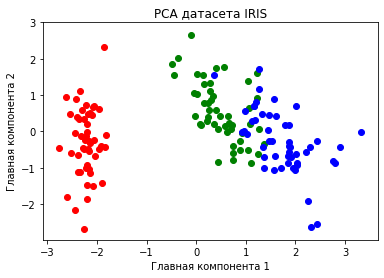

In [57]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y == i, 0], Z[y == i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

In [58]:
X_cutted = X[:, :2]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_cutted, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

In [60]:
k = 100

y_pred_train = knn(X_train, y_train, X_train, k)
y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма на трейне при k = {k}: {accuracy(y_pred_train, y_train):.3f}')
print(f'Точность алгоритма на тесте при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма на трейне при k = 100: 0.758
Точность алгоритма на тесте при k = 100: 0.667


Оценим качество knn при применении PCA

In [61]:
X_train, X_test, y_train, y_test = train_test_split(Z, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

In [62]:
k = 100

y_pred_train = knn(X_train, y_train, X_train, k)
y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма на трейне при k = {k}: {accuracy(y_pred_train, y_train):.3f}')
print(f'Точность алгоритма на тесте при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма на трейне при k = 100: 0.675
Точность алгоритма на тесте при k = 100: 0.567


### До применения PCA:
Точность алгоритма на трейне при k = 100: 0.500 \
Точность алгоритма на тесте при k = 100: 0.467

### При отбрасывании двух последних малозначащих признаков
Точность алгоритма на трейне при k = 100: 0.758 \
Точность алгоритма на тесте при k = 100: 0.667

### После применения PCA
Точность алгоритма на трейне при k = 100: 0.675 \
Точность алгоритма на тесте при k = 100: 0.567

При применении PCA наблюдаем увеличение качества модели на 10-17% \
При отбрасывании малозначащих признаков наблюдаем увеличение качества модели на 20-25%

# Задание 2

*Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции [numpy.linalg.svd()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html)

### Решение

In [63]:
def pca_sdv(X, d=1):
    X_T_X = X.T @ X
    U, s, W = np.linalg.svd(X_T_X)

    # Транспонируем матрицу W
    V = W.T
    
    pairs = sorted([[idx, item] for idx, item in enumerate(s)], key=lambda item: item[1])
    pairs.reverse()
    
    pairs = np.array(pairs, dtype=int)
    
    max_pairs = pairs[:d]
    max_ids = max_pairs[:, 0]
    
    WEIGHTS = V[max_ids].T
    
    return X @ WEIGHTS

In [64]:
Z_PCA_SDV = pca_sdv(X, 2)
Z_PCA_SDV

array([[-1.22336539, -0.6934415 ],
       [-0.66269093,  0.30398437],
       [-0.75107696, -0.17247746],
       [-0.5192636 , -0.02035411],
       [-1.24710926, -0.93861743],
       [-1.56881373, -1.51987721],
       [-0.78640916, -0.66034094],
       [-1.03245033, -0.52742811],
       [-0.26012838,  0.35334276],
       [-0.74306663,  0.0938125 ],
       [-1.54563707, -1.03450211],
       [-0.86527914, -0.60659065],
       [-0.63394816,  0.28760595],
       [-0.44096083,  0.16609477],
       [-2.1815187 , -1.49990602],
       [-2.27442124, -2.45688675],
       [-1.73240693, -1.46431708],
       [-1.18897171, -0.70969934],
       [-1.70573644, -1.19317092],
       [-1.40871435, -1.36120839],
       [-1.20319952, -0.42466315],
       [-1.28744036, -1.16492656],
       [-1.15815667, -1.01360233],
       [-0.82372881, -0.35880576],
       [-0.74258424, -0.64826075],
       [-0.64403077,  0.30884056],
       [-0.92276467, -0.57383382],
       [-1.24560354, -0.67469527],
       [-1.19962153,

In [65]:
X_train, X_test, y_train, y_test = train_test_split(Z_PCA_SDV, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

In [66]:
k = 100

y_pred_train = knn(X_train, y_train, X_train, k)
y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма на трейне при k = {k}: {accuracy(y_pred_train, y_train):.3f}')
print(f'Точность алгоритма на тесте при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма на трейне при k = 100: 0.675
Точность алгоритма на тесте при k = 100: 0.700
